# Inaugural Project

> **Note the following:** 
> 1. This is an example of how to structure your **inaugural project**.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `inauguralproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [6]:
import numpy as np

# autoreload modules when code is run. Otherwise, python will not see recent changes. 
%load_ext autoreload
%autoreload 2

# Import your own code
import matplotlib.pyplot as plt
from HouseholdSpecializationModel import HouseholdSpecializationModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Question 1

**Explain how you solve the model**

<function matplotlib.pyplot.show(close=None, block=None)>

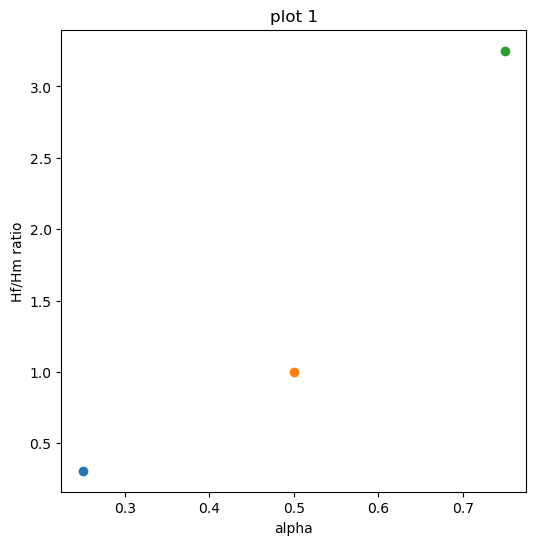

In [7]:
hsm = HouseholdSpecializationModelClass()

alpha_values = [0.25, 0.5, 0.75]

fig, ax = plt.subplots(figsize=(6, 6))

for alpha in alpha_values:
    hsm.par.alpha = alpha

    #solve the model
    opt = hsm.solve_discrete()

    #def the Hm/Hf ratio
    ratio = (opt.HF/opt.HM)

    #add data to scatterplot
    ax.scatter(alpha, ratio)

#define labels of the axes
ax.set_xlabel('alpha')
ax.set_ylabel('Hf/Hm ratio')
ax.set_title('plot 1')

#show plot
plt.show


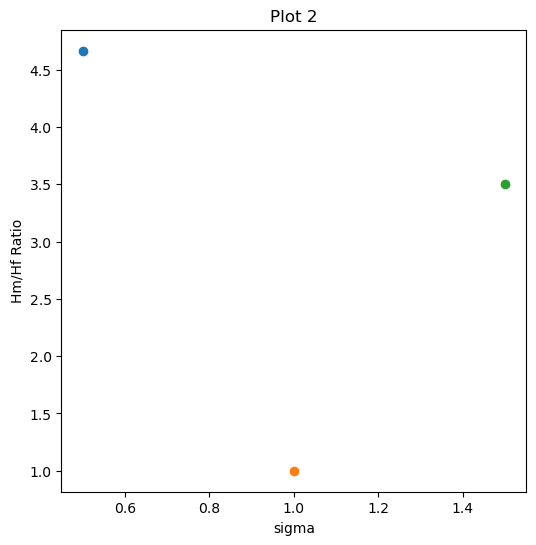

In [8]:
hsm = HouseholdSpecializationModelClass()

sigma_values = [0.5, 1.0, 1.5]
x = 0
fig, ax = plt.subplots(figsize=(6,6))

for sigma in sigma_values:
    hsm.par.sigma = sigma

    #solve the model
    opt = hsm.solve_discrete()

    #def the Hm/Hf ratio
    ratio = (opt.HF/opt.HM)

    #add data to the scatterplot
    ax.scatter(sigma, ratio)

#define the labels of the axes
ax.set_xlabel("sigma")
ax.set_ylabel("Hm/Hf Ratio")

ax.set_title("Plot 2")

#show plot
plt.show()


# Question 2

Explain your code and procedure

ValueError: x and y must have same first dimension, but have shapes (5,) and (1,)

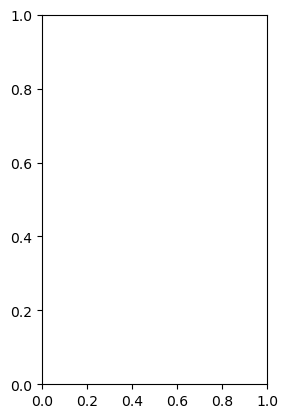

In [26]:
#create the log-Hf/Hm vector
log_ratio = np.log(ratio)

#get wages for male and female from the householdspecializationmodel
wF = hsm.par.wF_vec
wM = hsm.par.wM

#create the log-wF/wM vector 
log_wages = []
for femalewages in wF:
    log = np.log(femalewages/wM)
    log_wages.append(log)

#plot 
fig = plt.figure()
ax = fig.add_subplot(1,2,2)
ax.plot(log_wages, log_ratio)
ax.set_xlabel("wF")
ax.set_ylabel("log Hm/Hf Ratio")
ax.set_title("Plot 3")
plt.show()








# Question 3

Explain your code and procedure

In [10]:
# code

ADD CONCISE CONLUSION.